In [1]:
from flipper import liteMap
import matplotlib.pyplot as plt
import numpy as np
from cactusLib import filterLib
from cactusLib.cactusUtils import saveFits
from flipper import fftTools
import scipy


/home/cvargas/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
#Marsden Area

RA0 = 3.
RA1 = 106.75
DEC0 = -56.2
DEC1 = -49.0


lt = liteMap.liteMapFromFits("/home/cvargas/data/act/act_depots/cactus_depots/20180419/ACT_220_south_season_2_1way_v3_srcfree.fits")

ltw = liteMap.liteMapFromFits("/home/cvargas/data/act/act_depots/cactus_depots/20180419/ACT_220_south_season_2_1way_hits_v3.fits")

lt = lt.selectSubMap(RA0,RA1,DEC0,DEC1)
ltw = ltw.selectSubMap(RA0,RA1,DEC0,DEC1)

lt.data[:] = lt.data*np.sqrt(ltw.data)/np.sqrt(np.max(ltw.data))

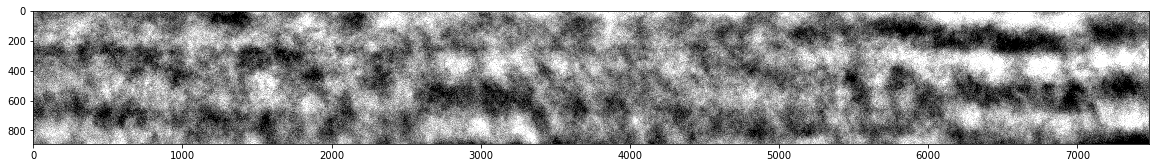

In [3]:
plt.figure(figsize=(20,15))
plt.imshow(lt.data,cmap="gray",vmin = -500., vmax= 500.)
plt.show()

saveFits(lt.data/np.sqrt(ltw.data)*np.sqrt(np.max(ltw.data)),"Original_noise.fits",lt.header)

In [4]:
lt_std = np.std(lt.data)
lt_std

235.11394114697998

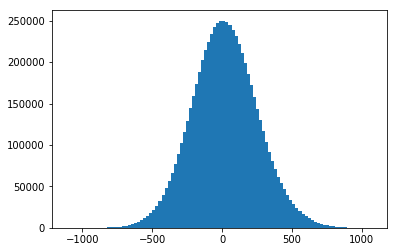

In [5]:
plt.hist(lt.data.flatten(),100)
plt.show()

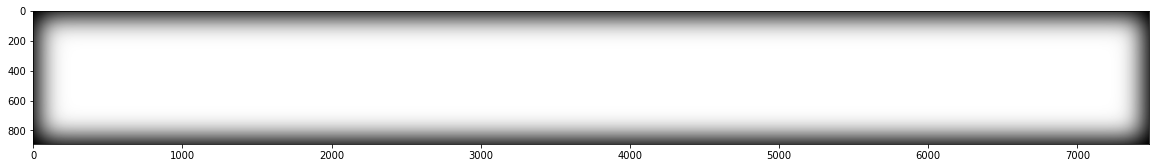

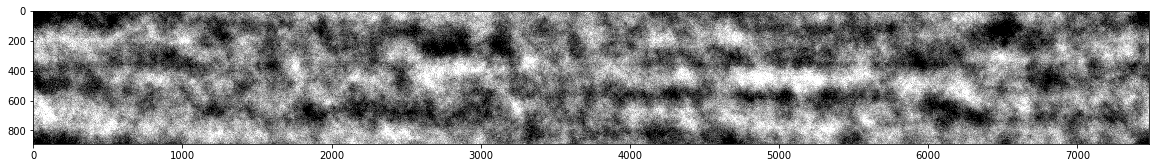

In [6]:
#Example of one new random realization

mu = 0.
sigma = 1.
Ny,Nx = lt.data.shape
new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
new_exp = new/np.abs(new)


#We need the apodize the map before taking the FFT ###############
#or the spectrum will be too noise

noiseMap = lt.copy()

pad = 40
extraYPad = 0
apodNy,apodNx = noiseMap.data.shape
apod = noiseMap.data.copy()
apod[:] = 0.0
apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
N_apod = scipy.ndimage.gaussian_filter(apod,80,mode="constant")

plt.figure(figsize=(20,15))
plt.imshow(N_apod,cmap="gray")
plt.show()

noiseMap.data *= N_apod

FTNM = fftTools.fftFromLiteMap(noiseMap)

a = np.abs(FTNM.kMap)

##################################################################

#Factor by the apodization
Ny,Nx = FTNM.kMap.shape
A = np.sqrt(Nx*Ny)/(np.sqrt(np.sum(np.abs(N_apod)**2)))

M_fft2 = a*new_exp

M_fft2 *= A

M_fft2 = filterLib.symmetrizeFFT(M_fft2)
M = np.real(np.fft.ifft2(M_fft2))


plt.figure(figsize=(20,15))
plt.imshow(M,cmap="gray",vmin = -500., vmax= 500.)
plt.show()


In [7]:
A

1.1296105155595888

In [8]:
FTmap = fftTools.fftFromLiteMap(lt)

In [9]:
bins = np.linspace(1000.,6000.,100)

#No factor

#FT = np.fft.fft2(white_noise)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)
FT = np.fft.fft2(A*lt.data*N_apod)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)
mL = FTmap.modLMap
Cl0 = []
ell0 = []
for i in range(len(bins)-1):
    c1 = mL>bins[i]
    c2 = mL<bins[i+1]
    c = c1.astype(int)*c2.astype(int)
    c = c.astype(bool)
    #Clbin = np.mean(smooth[c])
    FT_abs = np.abs(FT)
    Clbin = np.mean(FT_abs[c])
    lbin = np.mean(FTmap.modLMap[c])
    #lbin = np.mean([bins[i],bins[i+1]])
    #print lbin
    Cl0.append(Clbin)
    ell0.append(lbin)

    
FT = np.fft.fft2(A*M*N_apod)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)

Cl1 = []
ell1 = []

for i in range(len(bins)-1):
    c1 = mL>bins[i]
    c2 = mL<bins[i+1]
    c = c1.astype(int)*c2.astype(int)
    c = c.astype(bool)
    #Clbin = np.mean(smooth[c])
    FT_abs = np.abs(FT)
    Clbin = np.mean(FT_abs[c])
    lbin = np.mean(FTmap.modLMap[c])
    #lbin = np.mean([bins[i],bins[i+1]])
    #print lbin
    Cl1.append(Clbin)
    ell1.append(lbin)  

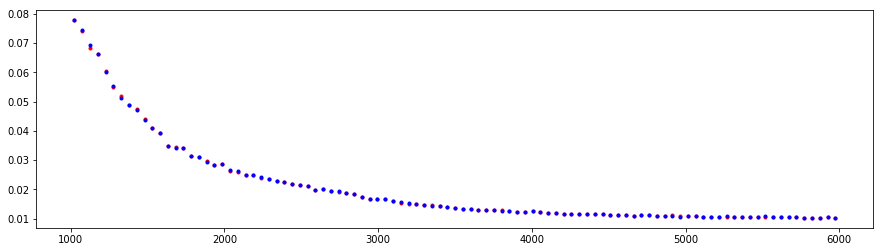

In [10]:
plt.figure(figsize=(15,4))
plt.plot(ell0,Cl0,"r.")
plt.plot(ell1,Cl1,"b.")


In [11]:
def new_realization(lt,i,plot=True,saveMap=True): 
    #Getting new exponential from a random realization
    mu = 0.
    sigma = 1.
    Ny,Nx = lt.data.shape
    new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
    new_exp = new/np.abs(new)


    #We need the apodize the map before taking the FFT ###############
    #or the spectrum will be too noise

    noiseMap = lt.copy()

    pad = 80
    extraYPad = 0
    apodNy,apodNx = noiseMap.data.shape
    apod = noiseMap.data.copy()
    apod[:] = 0.0
    apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
    N_apod = scipy.ndimage.gaussian_filter(apod,40,mode="constant")

    noiseMap.data *= N_apod

    FTNM = fftTools.fftFromLiteMap(noiseMap)

    a = np.abs(FTNM.kMap)

    ##################################################################

    #Factor by the apodization
    Ny,Nx = FTNM.kMap.shape
    A = np.sqrt(Nx*Ny)/(np.sqrt(np.sum(np.abs(N_apod)**2)))

    M_fft2 = a*new_exp

    M_fft2 *= A

    M_fft2 = filterLib.symmetrizeFFT(M_fft2)
    M = np.real(np.fft.ifft2(M_fft2))

    if plot:
        plt.figure(figsize=(20,15))
        plt.imshow(M,cmap="gray",vmin = -500., vmax= 500.)

    if saveMap:
        saveFits(M/np.sqrt(ltw.data)*np.sqrt(np.max(ltw.data)),"noise{}.fits".format(i),lt.header)
    return M
    

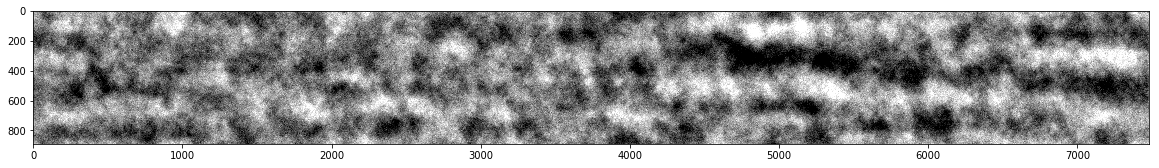

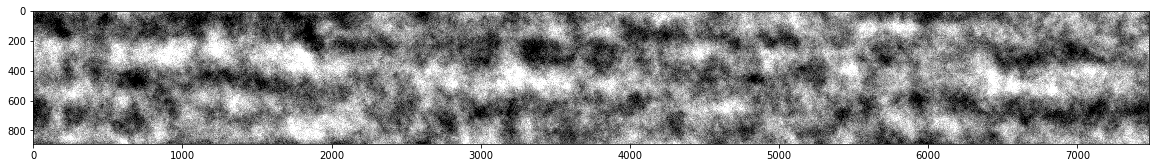

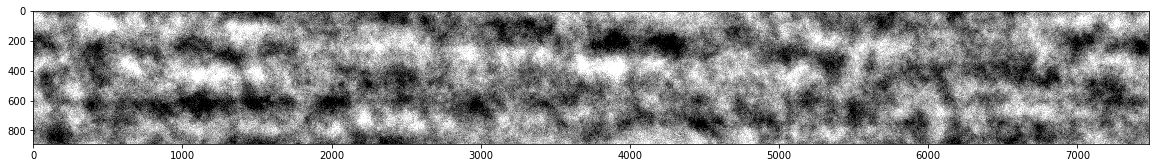

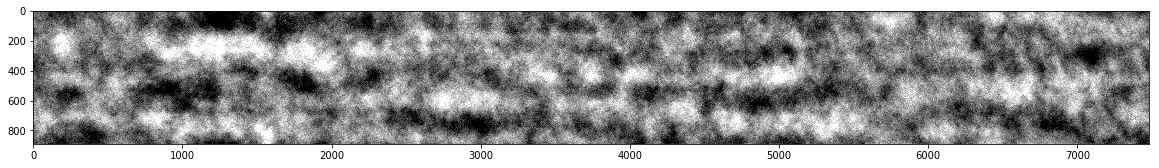

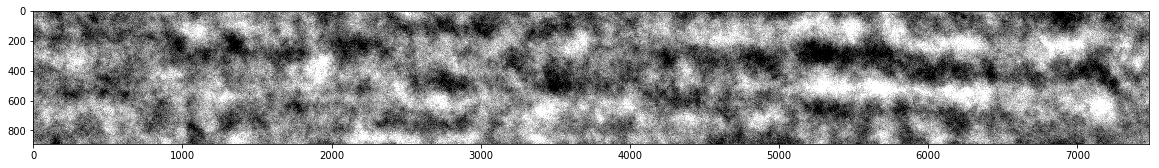

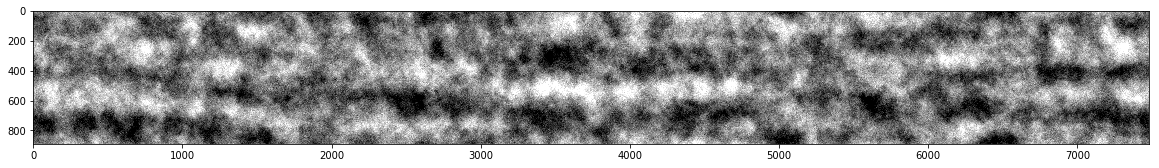

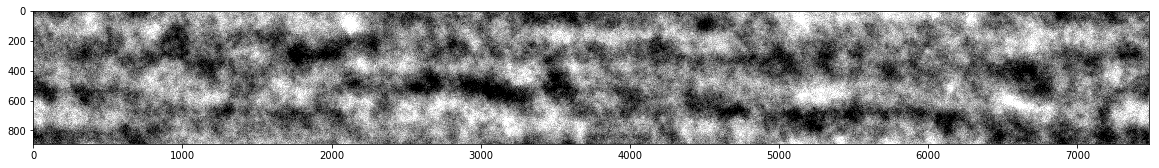

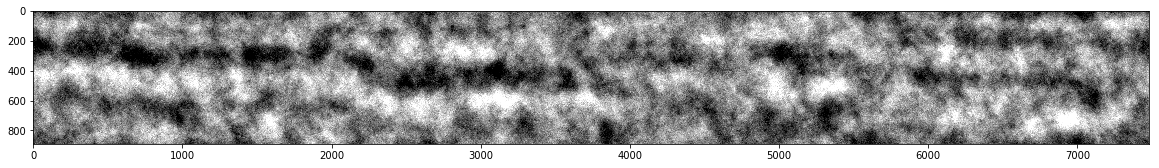

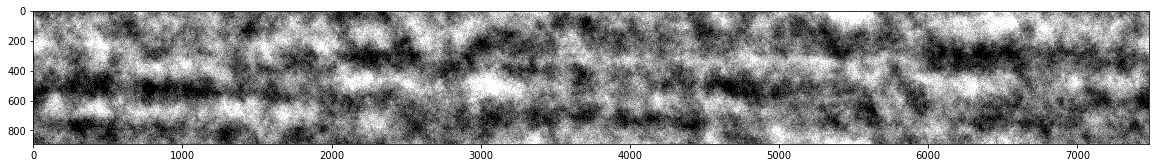

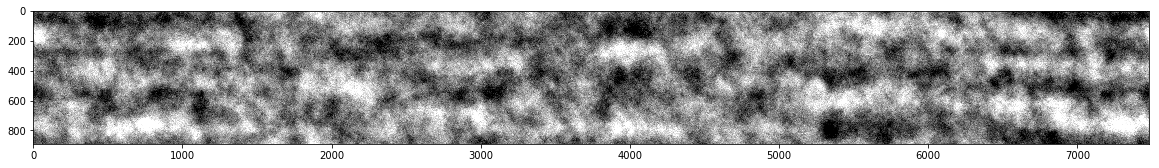

In [12]:
for i in range(10):
    new_realization(lt,i,saveMap=True)